# Initialisation

In [1]:

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
import os
warnings.filterwarnings('ignore')

# Configuration externe
sys.path.append('..')
from config.parameters import DATA_CONFIG, EDA_CONFIG

figsize = EDA_CONFIG['figsize']

print("=== ANALYSE BIVARIÉE - DIRECT ASSURANCE ===")


=== ANALYSE BIVARIÉE - DIRECT ASSURANCE ===


# CHARGEMENT DES DONNEES

In [2]:
# Charger les données
full_path = os.path.join('..', DATA_CONFIG['raw_data_path'], DATA_CONFIG['train_file'])
df = pd.read_csv(full_path)
target_col = DATA_CONFIG['target_column']

# Identifier les types de variables (exclure PolicyId)
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                if col not in ['PolicyId']]
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns 
                   if col not in ['PolicyId']]

print(f"Variable cible : {target_col}")
print(f"Variables numériques ({len(numeric_cols)}) : {numeric_cols}")
print(f"Variables catégorielles ({len(categorical_cols)}) : {categorical_cols}")


Variable cible : PrimeCommerciale
Variables numériques (4) : ['AgeConducteur', 'BonusMalus', 'AgeVehicule', 'PrimeCommerciale']
Variables catégorielles (10) : ['SexeConducteur', 'StatutMatrimonial', 'FrequencePaiement', 'CodeProfession', 'ClasseVehicule', 'PuissanceVehicule', 'CarburantVehicule', 'UsageVehicule', 'Garage', 'Region']


# CORRÉLATIONS AVEC LA CIBLE 

In [3]:
def analyze_numeric_target_relationship(df, numeric_cols, target_col):
    """Analyse des relations numériques avec la variable cible"""
    
    correlations = []
    
    print("=== CORRÉLATIONS AVEC LA PRIME COMMERCIALE ===")
    
    for col in numeric_cols:
        if col != target_col: 
            # Calculer corrélations Pearson et Spearman
            pearson_corr, pearson_p = pearsonr(df[col].dropna(), 
                                             df[target_col][df[col].notna()])
            spearman_corr, spearman_p = spearmanr(df[col].dropna(), 
                                                df[target_col][df[col].notna()])
            
            correlations.append({
                'Variable': col,
                'Pearson_r': pearson_corr,
                'Pearson_p': pearson_p,
                'Spearman_r': spearman_corr,
                'Spearman_p': spearman_p
            })
            
            print(f"\n{col}:")
            print(f"  Pearson  : r={pearson_corr:.3f}, p={pearson_p:.3f}")
            print(f"  Spearman : r={spearman_corr:.3f}, p={spearman_p:.3f}")
    
    # Créer DataFrame de synthèse
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.reindex(corr_df['Pearson_r'].abs().sort_values(ascending=False).index)
    
    return corr_df

# Exécution
correlation_results = analyze_numeric_target_relationship(df, numeric_cols, target_col)
print(f"\n=== SYNTHÈSE DES CORRÉLATIONS ===")
print(correlation_results.round(3))


=== CORRÉLATIONS AVEC LA PRIME COMMERCIALE ===

AgeConducteur:
  Pearson  : r=-0.170, p=0.000
  Spearman : r=-0.214, p=0.000

BonusMalus:
  Pearson  : r=0.377, p=0.000
  Spearman : r=0.360, p=0.000

AgeVehicule:
  Pearson  : r=-0.459, p=0.000
  Spearman : r=-0.549, p=0.000

=== SYNTHÈSE DES CORRÉLATIONS ===
        Variable  Pearson_r  Pearson_p  Spearman_r  Spearman_p
2    AgeVehicule     -0.459        0.0      -0.549         0.0
1     BonusMalus      0.377        0.0       0.360         0.0
0  AgeConducteur     -0.170        0.0      -0.214         0.0


# VISUALISATIONS NUMÉRIQUES 

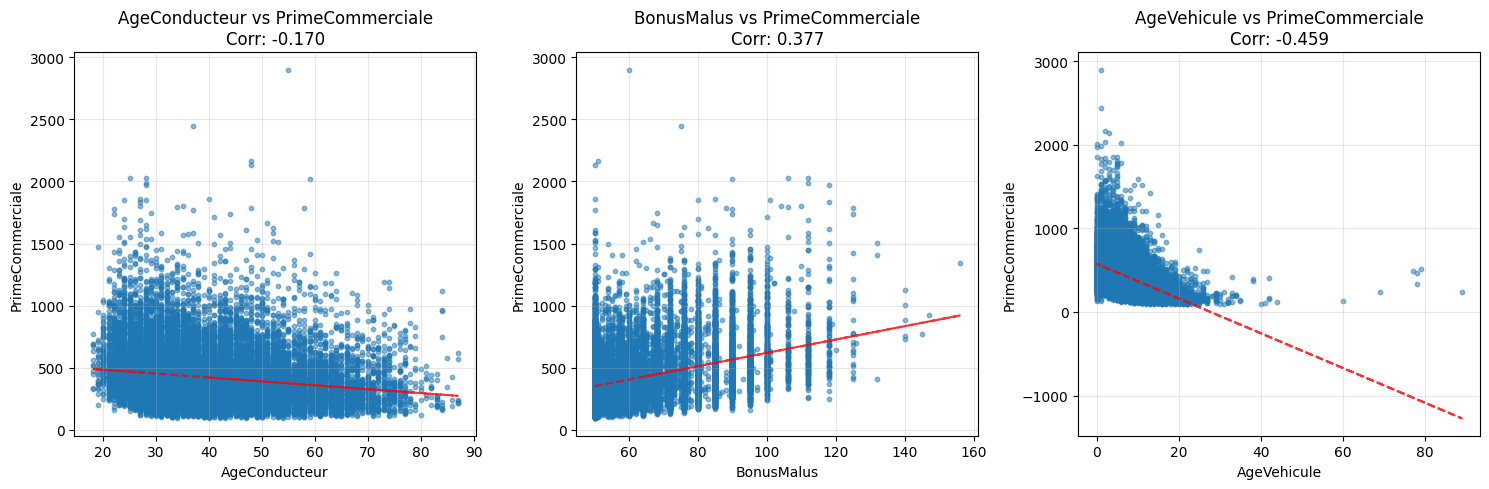

In [4]:
def plot_numeric_relationships(df, numeric_cols, target_col, max_plots=6):
    """Visualiser les relations numériques avec la cible"""
    
    # Sélectionner les variables à analyser
    variables_to_plot = [col for col in numeric_cols if col != target_col][:max_plots]
    
    n_vars = len(variables_to_plot)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    if n_rows == 1 and n_cols == 1:
        axes = [axes]  
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten() 
    else:
        axes = axes.flatten()  
    
    for i, col in enumerate(variables_to_plot):
        if i < len(axes):
            axes[i].scatter(df[col], df[target_col], alpha=0.5, s=10)
            
            # Ajouter ligne de tendance
            valid_data = df[[col, target_col]].dropna()
            if len(valid_data) > 1:
                z = np.polyfit(valid_data[col], valid_data[target_col], 1)
                p = np.poly1d(z)
                axes[i].plot(valid_data[col], p(valid_data[col]), "r--", alpha=0.8)
            
            # Calcul corrélation pour le titre
            corr, _ = pearsonr(valid_data[col], valid_data[target_col])
            
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target_col)
            axes[i].set_title(f'{col} vs {target_col}\nCorr: {corr:.3f}')
            axes[i].grid(True, alpha=0.3)
    
    # Masquer les axes inutilisés
    for j in range(len(variables_to_plot), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


# Exécution
plot_numeric_relationships(df, numeric_cols, target_col)


# ANALYSE CATÉGORIELLE-CIBLE 

In [5]:

def analyze_categorical_target_impact(df, categorical_cols, target_col):
    """Analyser l'impact des variables catégorielles sur la cible"""
    
    results = []
    
    print("=== IMPACT DES VARIABLES CATÉGORIELLES SUR LA PRIME ===")
    
    for col in categorical_cols:
        print(f"\n--- {col} ---")
        
        # Statistiques par modalité
        group_stats = df.groupby(col)[target_col].agg([
            'count', 'mean', 'median', 'std'
        ]).round(2)
        
        print("Statistiques par modalité:")
        print(group_stats)
        
        # Test ANOVA (si plus de 2 groupes)
        groups = [group[target_col].dropna() for name, group in df.groupby(col)]
        
        if len(groups) > 2:
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"Test ANOVA: F={f_stat:.3f}, p={p_value:.3f}")
        else:
            # Test t pour 2 groupes
            if len(groups) == 2:
                t_stat, p_value = stats.ttest_ind(groups[0], groups[1])
                print(f"Test t: t={t_stat:.3f}, p={p_value:.3f}")
        
        # Stocker les résultats
        results.append({
            'Variable': col,
            'Nb_modalites': len(group_stats),
            'F_statistic': f_stat if len(groups) > 2 else np.nan,
            'p_value': p_value,
            'Significant': p_value < 0.05
        })
    
    return pd.DataFrame(results)

# Exécution
categorical_results = analyze_categorical_target_impact(df, categorical_cols, target_col)
print(f"\n=== SYNTHÈSE TESTS STATISTIQUES ===")
print(categorical_results)


=== IMPACT DES VARIABLES CATÉGORIELLES SUR LA PRIME ===

--- SexeConducteur ---
Statistiques par modalité:
                count    mean  median     std
SexeConducteur                               
F                7672  389.99  347.15  195.23
M               14809  436.74  391.40  229.11
Test t: t=-15.238, p=0.000

--- StatutMatrimonial ---
Statistiques par modalité:
                   count    mean  median     std
StatutMatrimonial                               
Cohabiting          4630  410.72  363.40  219.38
Divorced              88  387.54  358.85  163.29
Married             1568  410.21  359.45  218.34
Single               865  391.11  346.40  211.57
Widowed              221  419.09  352.10  224.22
Test ANOVA: F=1.855, p=0.115

--- FrequencePaiement ---
Statistiques par modalité:
                   count    mean  median     std
FrequencePaiement                               
Annual              7680  359.92  321.25  181.44
Half-yearly        12486  437.24  394.50  215.41
Monthl

# VISUALISATIONS CATÉGORIELLES 

<Figure size 1200x800 with 0 Axes>

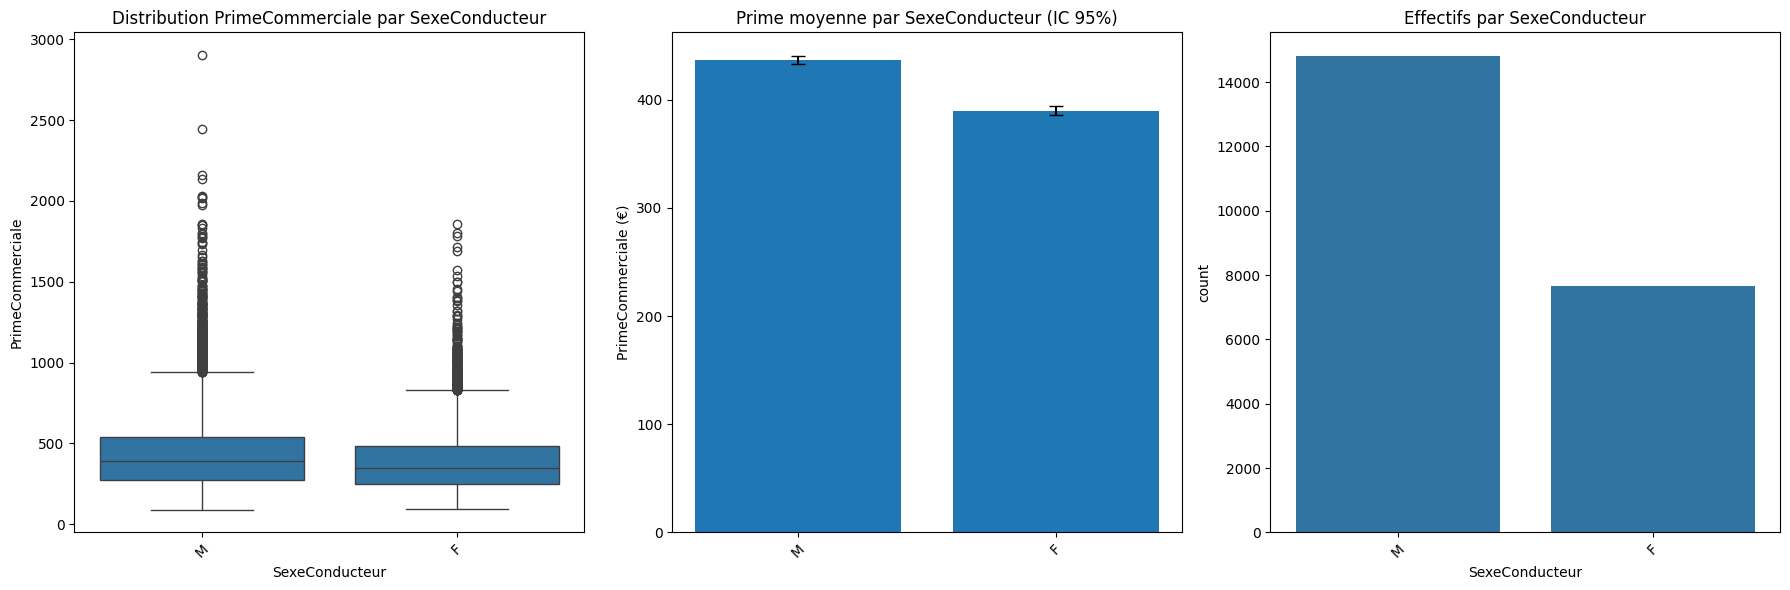

<Figure size 1200x800 with 0 Axes>

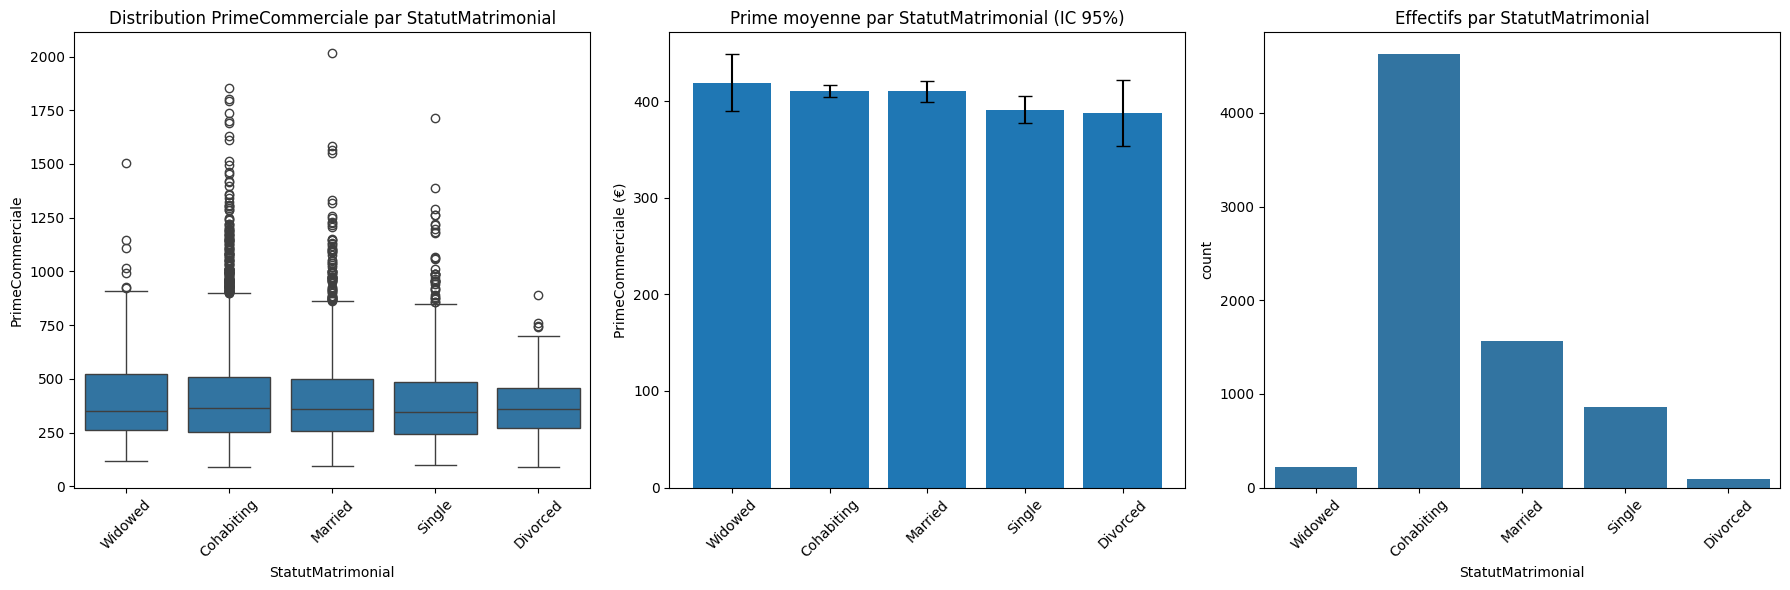

<Figure size 1200x800 with 0 Axes>

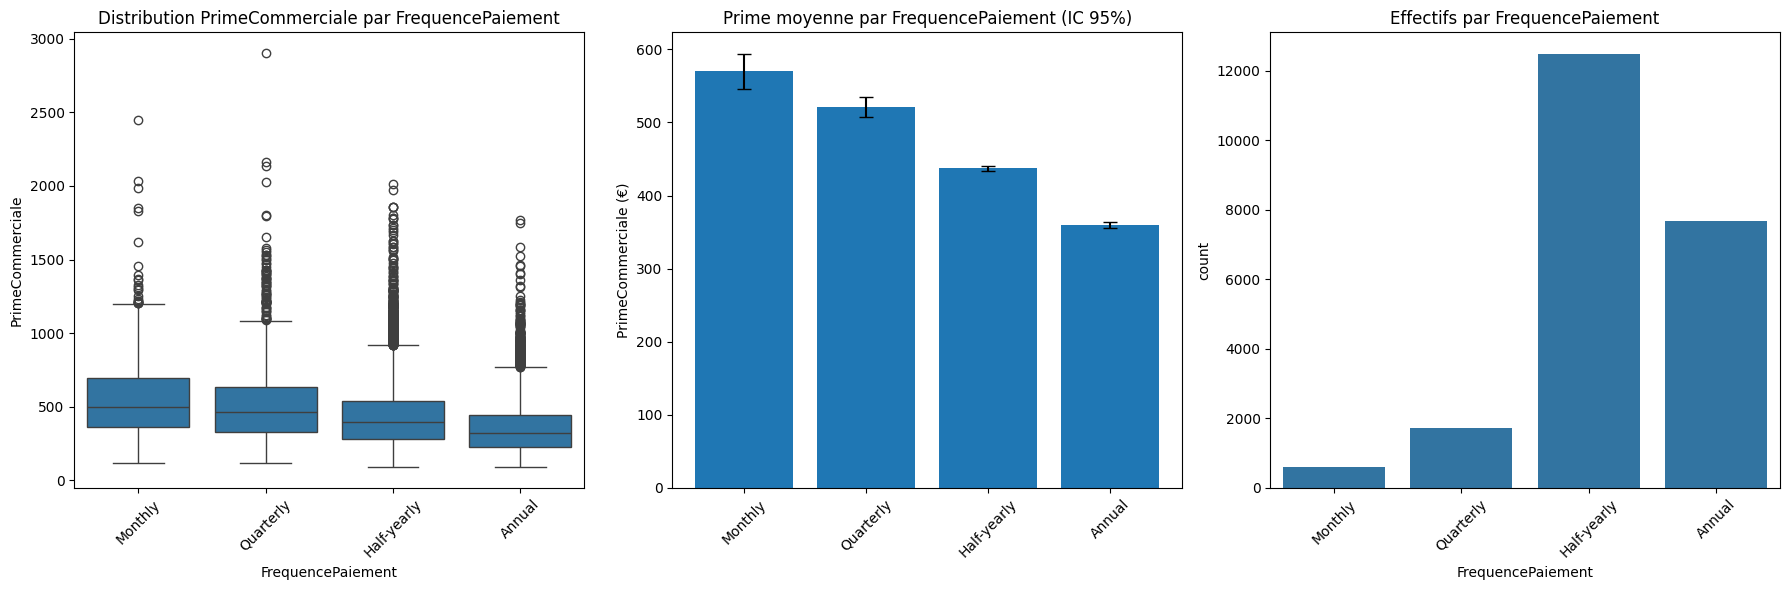

<Figure size 1200x800 with 0 Axes>

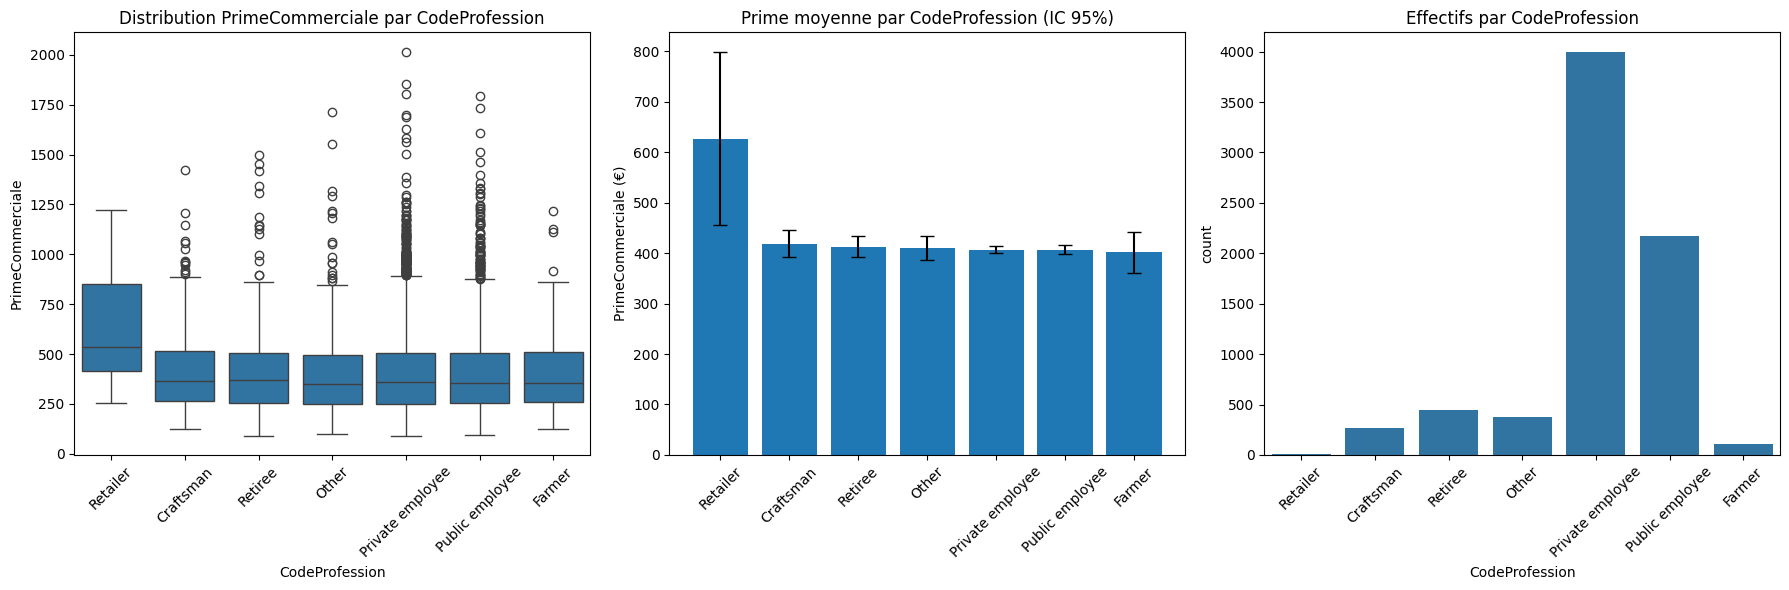

<Figure size 1200x800 with 0 Axes>

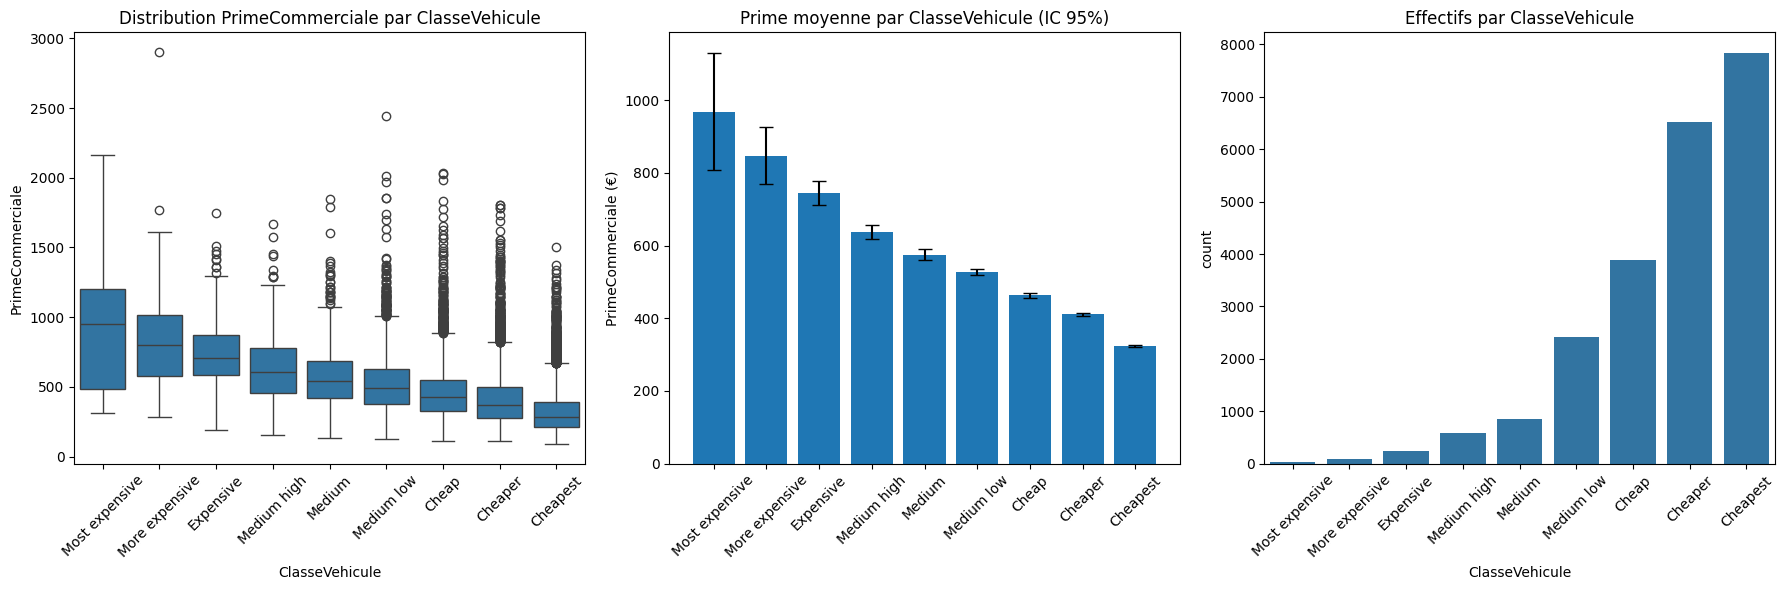

<Figure size 1200x800 with 0 Axes>

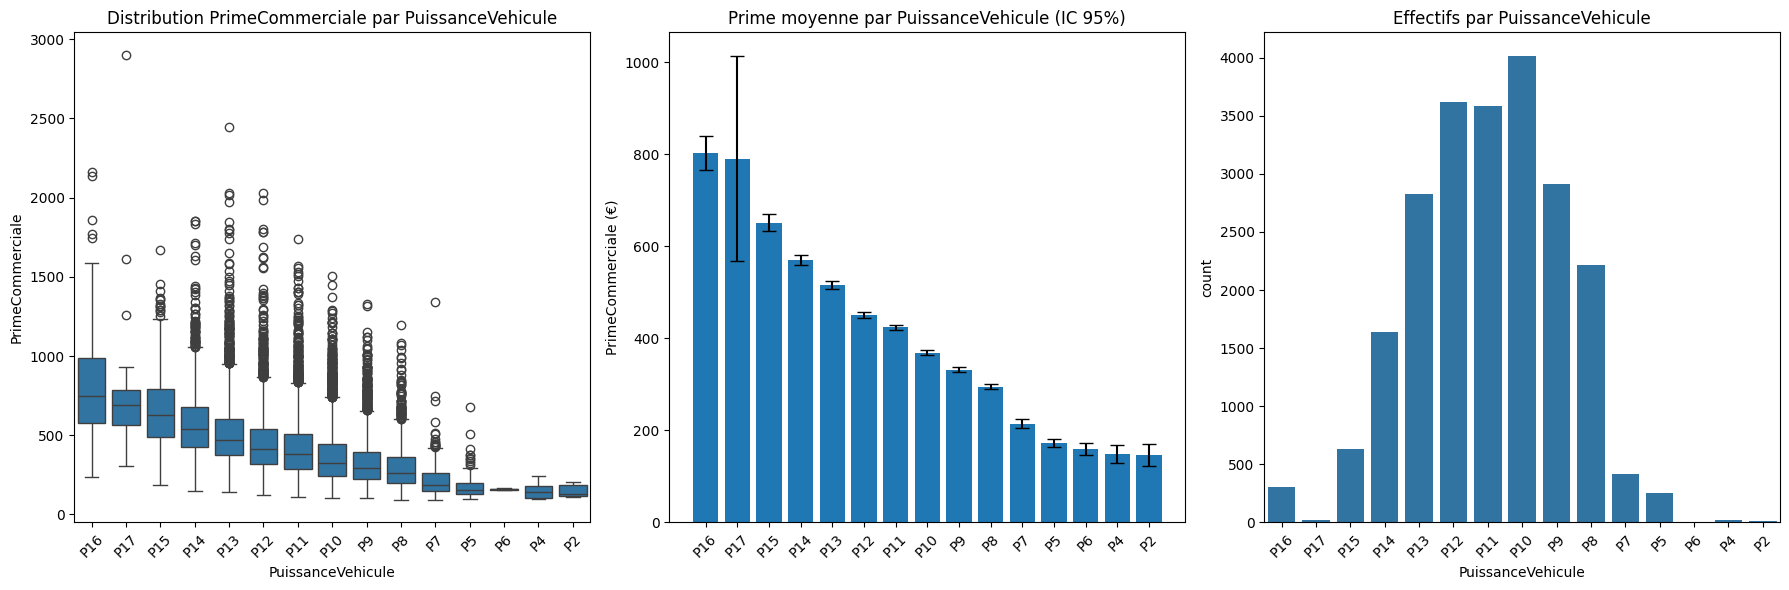

In [6]:

def plot_categorical_target_relationships(df, categorical_cols, target_col, max_plots=6):
    """Visualiser l'impact des variables catégorielles sur la cible"""
    
    # Sélectionner les variables les plus significatives
    variables_to_plot = categorical_cols[:max_plots]
    
    for col in variables_to_plot:
        plt.figure(figsize=(12, 8))
        
        data_to_plot = df
        order = df.groupby(col)[target_col].mean().sort_values(ascending=False).index

        # Créer les sous-graphiques
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Box plot
        sns.boxplot(data=data_to_plot, x=col, y=target_col, order=order, ax=ax1)
        ax1.set_title(f'Distribution {target_col} par {col}')
        ax1.tick_params(axis='x', rotation=45)
        
        # Bar plot des moyennes avec IC
        means = data_to_plot.groupby(col)[target_col].mean().reindex(order)
        stds = data_to_plot.groupby(col)[target_col].std().reindex(order)
        counts = data_to_plot.groupby(col)[target_col].count().reindex(order)
        
        # Intervalles de confiance
        sem = stds / np.sqrt(counts)  
        ci = 1.96 * sem 
        
        ax2.bar(range(len(means)), means.values, yerr=ci.values, capsize=5)
        ax2.set_xticks(range(len(means)))
        ax2.set_xticklabels(means.index, rotation=45)
        ax2.set_title(f'Prime moyenne par {col} (IC 95%)')
        ax2.set_ylabel(f'{target_col} (€)')
        
        # Count plot
        sns.countplot(data=data_to_plot, x=col, order=order, ax=ax3)
        ax3.set_title(f'Effectifs par {col}')
        ax3.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

# Exécution
plot_categorical_target_relationships(df, categorical_cols, target_col)
